In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 0
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 19日 星期五 22:04:37 CST


In [4]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-19_10-20-13_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-19_10-20-13_noup


# 初始化棋局

In [5]:
HUMAN_FIRST = False
MOVE = 'human' if HUMAN_FIRST else 'computer'


In [6]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [7]:
state.currentplayer = 'w'
MOVE = 'computer'

# 从这里开始下棋

In [8]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    while (move not in GameBoard.get_legal_moves(statestr,current_player=state.currentplayer)):
        print("invalid move {}, please reinput:".format(move))
        move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1600,temp_round=-1,repeat_noise=False,c_puct=5,dnoise=False)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
moves.append(move)

b0c2


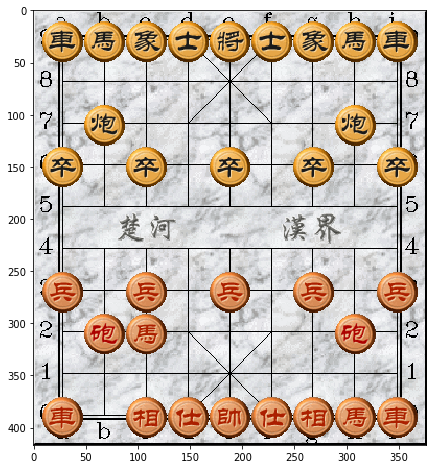

In [9]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)

# analysis

In [15]:
for move in network_player.mcts_policy._root._children:
    node = network_player.mcts_policy._root._children[move]
    print(move,node._n_visits,node._P,node._Q)

a0a1 1 0.0007670729 -0.0074112252332270145
a0a2 0 0.00028196507 0
a3a4 0 0.0001748193 0
b0a2 55 0.024468575 0.013015325398671186
b0c2 623 0.4431352 0.06378924897784082
b2a2 1 0.0005630622 -0.021126046776771545
b2c2 25 0.010421606 0.019876158717088407
b2d2 8 0.0047616856 -0.011645253165625036
b2e2 308 0.20313318 0.013805249498026164
b2f2 0 0.0002112179 0
b2g2 0 0.00043454985 0
b2b1 1 0.00069580413 -0.025833608582615852
b2b3 3 0.001730992 0.008631284348666668
b2b4 1 0.0008030702 -0.005025791469961405
b2b5 1 0.0005819938 -0.013884009793400764
b2b6 42 0.015321669 0.027280853304546323
b2b9 8 0.0055028335 -0.037480738712474704
c3c4 0 0.00016430713 0
e0e1 0 0.0001163158 0
e3e4 0 5.192577e-05 0
g3g4 0 7.754394e-05 0
h0g2 101 0.056538653 0.006862739499284896
h0i2 0 0.0004574938 0
h2c2 0 4.7916707e-05 0
h2d2 0 4.1972602e-05 0
h2e2 49 0.024736611 0.0006485023139025631
h2f2 0 3.685693e-05 0
h2g2 7 0.003150474 0.01557471485076738
h2i2 0 0.00021831875 0
h2h1 0 5.134064e-05 0
h2h3 0 4.3589775e-05 0
h

In [16]:
network

((<tensorflow.python.client.session.Session at 0x7f813c1a5e10>,
  <tensorflow.python.framework.ops.Graph at 0x7f8230720cc0>),
 ((<tf.Tensor 'Placeholder:0' shape=(?, 10, 9, 14) dtype=float32>,
   <tf.Tensor 'training_mode:0' shape=<unknown> dtype=bool>),
  (<tf.Tensor 'concat_200:0' shape=(?, 2086) dtype=float32>,
   <tf.Tensor 'concat_201:0' shape=(?, 1) dtype=float32>)))

In [17]:
graph = network[0][1]
sess = network[0][0]

In [18]:
import tensorflow as tf
with graph.as_default():
    regularizer = tf.contrib.layers.l2_regularizer(scale=1e-4)
    regular_variables = tf.trainable_variables()
    l2_loss = tf.contrib.layers.apply_regularization(regularizer, regular_variables)

In [19]:
with graph.as_default():
    print(sess.run(l2_loss))

0.32124707
